<a href="https://colab.research.google.com/github/rp1177/CS461-MachineLearning-Principles/blob/main/Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import csv
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import random

from scipy.special import logsumexp  # to deal with potential overflow issues


def set_seed(seed):  # For reproducibility, fix random seeds.
  random.seed(seed)
  np.random.seed(seed)

set_seed(42)

# Fashion MNIST

Download the Fashion MNIST dataset from [here](https://drive.google.com/drive/folders/1BnU7wVriolasZAZ1bSDTyll1Tp61hP1c?usp=sharing). It consists of 16 x 16 grayscale images (downsized from 28 x 28 for efficiency), split into 50,000 training and 10,000 validation images. Each image is labeled as one of 10 clothing categories (e.g., dress, sandal, shirt). We will assume that we have the directory `data/FashionMNIST/` in our Google Drive account. Let's load the data and stare at it.  

In [ ]:
# Load the Drive helper and mount. You will have to authorize this operation.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
datadir = '/content/drive/My Drive/data/FashionMNIST/'
label_names = ['tshirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']  # Hardcoded

class FashionMNIST:

  def __init__(self, split):
    assert split in ['Tr', 'Vl']  # We don't have a test set
    self.inputs = np.load('{:s}x{:s}.npy'.format(datadir, split))  # (N, 16^2)
    self.labels = np.load('{:s}y{:s}.npy'.format(datadir, split))  # (N, 10)
    self.num_examples, self.dim = self.inputs.shape
    self.num_labels = self.labels.shape[1]

    # Partition data by labels
    self.partition = [self.inputs[np.where(np.argmax(self.labels, axis=1) == y)[0]] for y in range(self.num_labels)]

In [ ]:
data_train = FashionMNIST('Tr')
data_val = FashionMNIST('Vl')

print(data_train.inputs.shape, data_val.inputs.shape)

(50000, 256) (10000, 256)


In [ ]:
def show_image(image, ax=None):
  width = int(np.sqrt(image.shape[0]))
  image = image.reshape(width, width)
  if ax == None:
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
  imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
  imgplot.set_interpolation('nearest')
  ax.xaxis.set_ticks_position('top')
  ax.yaxis.set_ticks_position('left')
  plt.axis('off')

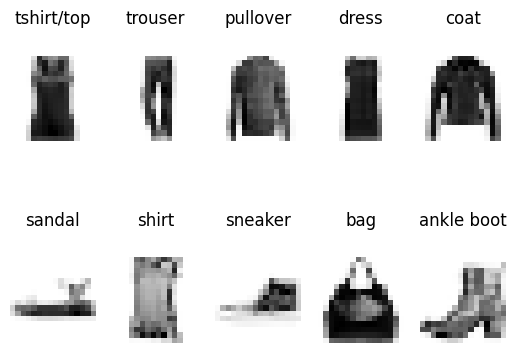

In [ ]:
for y in range(10):
  ax = plt.subplot(2, 5, y + 1)
  ax.clear()
  show_image(data_train.partition[y][0], ax)
  ax.set_title(label_names[y])

The images are a little blurry because we downsized them, but they will do.

# Gaussian Mixture Model (GMM)

A **Gaussian mixture model** (GMM) with $K$ components has learnable parameters $\pi \in \mathbb{R}^K$ and $\mu_k \in \mathbb{R}^K, \Sigma_k \in \mathbb{R}^{K \times K}$ for each $k = 1 \ldots K$, where it is always assumed that

- $\pi$ is a (full-support) distribution over the $K$ components. So $\pi_k > 0$ and $\sum_{k=1}^K \pi_k = 1$.
- $\Sigma_k$ is a symmetric and positive definite (thus invertible) for each $k$.

A GMM  defines a joint distribution over $k \in \{1 \ldots K\}$ and $x \in \mathbb{R}^d$ by
$$
p(k,x) = \pi_k \times \mathcal{N}(\mu_k, \Sigma_k)(x)
$$
where $\mathcal{N}(\mu_k, \Sigma_k)(x)$ is the probability of $x$ under the Gaussian distribution with mean $\mu_k$ and covariance matrix $\Sigma_k$. For practical reasons, we do the following:  

- We optionally restrict ourselves to *diagonal* covariance matrices to make calculation simpler and more efficient.
- We work in *log space* for numerical stability, that is: $\log p(k,x) = \log \pi_k + \log \mathcal{N}(\mu_k, \Sigma_k)(x)$.
- We make all variables multidimensional tensors so that we can use linear algebraic operations instead of for loops.

In [ ]:
class GMM:

  def __init__(self, dim, num_components, diag=False):
    self.pi = np.full(num_components, 1. / num_components)  # (K,)
    self.mu = np.zeros((num_components, dim))  # (K, d)
    if diag:
      self.sigma = np.ones((num_components, dim))  # (K, d)
    else:
      self.sigma = np.array([np.identity(dim) for _ in range(num_components)])   # (K, d, d)
    self.diag = diag

  def compute_log_probs(self, inputs):  # (N, d)
    log_pi = np.log(self.pi)[:, np.newaxis]  # (K, 1)
    diffs = inputs[np.newaxis, :, :] - self.mu[:, np.newaxis, :]  # (K, N, d)

    #7,200,100 - diffs og
    #7,200,100 - transposed



    # TODO: implement, do not use for loops. You'd want to distinguish the diagonal vs non-diagonal case (self.diag).'
    log_probs = None
    d = inputs.shape[1]

    if(self.diag):

      det = np.sum(np.log(self.sigma), axis=1)
      det = det[:, np.newaxis]

      inv = (1 / self.sigma)
      inv_matrix =  np.apply_along_axis(np.diag, -1, inv) #make own inv matrix to maintain shape

      pt1 = (-0.5) * np.einsum('KNd, Kdd, KdN->KN', diffs, inv_matrix, np.transpose(diffs, (0,2,1))) #diff calculation -1/2 (x-u)^T * inv * (x-u)
      pt2 = (-0.5 * (d * np.log(2 * math.pi))) # -1/2 * d * log(2pi)
      pt3 = (-0.5 * det) #-1/2 * det

      log_prob_density = pt1 + pt2 + pt3
      log_probs = log_pi +  log_prob_density  # (K, N): log p(k, inputs[i])


    else:

      #do basic default calculations using the np functions:
      det = np.linalg.slogdet(self.sigma)[1]
      det = det[:, np.newaxis]
      inv = np.linalg.inv(self.sigma)

      pt1 = (-0.5) * np.einsum('KNd, Kdd, KdN->KN', diffs, inv ,np.transpose(diffs, (0,2,1)))
      pt2 = (-0.5 * inputs.shape[1] * np.log(2 * np.pi))
      pt3 = (-0.5 * det)

      log_prob_density = pt1 + pt2 + pt3
      log_probs = log_pi + log_prob_density




    return log_probs

  def compute_posteriors(self, inputs):  # (N, d)
    log_probs = self.compute_log_probs(inputs)  # (K, N): log p(k, x)
    marginal_log_probs = logsumexp(log_probs, axis=0)  # (N,): log p(x)
    marginal_log_likelihood = marginal_log_probs.mean()  # Scalar
    posteriors = np.exp(log_probs - marginal_log_probs[np.newaxis, :])  # (K, N): p(k|x)
    return posteriors, marginal_log_likelihood, marginal_log_probs

In [ ]:
import unittest

from scipy.stats import multivariate_normal

class TestGMM(unittest.TestCase):

  def setUp(self):
    set_seed(42)
    self.dim = 100
    self.num_components = 7
    self.num_examples = 200
    self.power = 2 # Check for numerical stability

    self.inputs = np.random.randn(self.num_examples, self.dim)

  def test_model_diag(self):
    model = self.init_model(diag=True)
    log_probs_gold = self.get_log_probs_gold(model)
    log_probs = model.compute_log_probs(self.inputs)
    for k in range(self.num_components):
      for i in range(self.num_examples):
        self.assertAlmostEqual(log_probs[k, i], log_probs_gold[k, i])

  def test_model_nondiag(self):
    model = self.init_model(diag=False)
    log_probs_gold = self.get_log_probs_gold(model)
    log_probs = model.compute_log_probs(self.inputs)
    for k in range(self.num_components):
      for i in range(self.num_examples):
        self.assertAlmostEqual(log_probs[k, i], log_probs_gold[k, i])

  def get_log_probs_gold(self, model):
    log_probs_gold = []
    for k in range(self.num_components):
      dist = multivariate_normal(mean=model.mu[k], cov=(np.diag(model.sigma[k]) if model.diag else model.sigma[k]))
      log_probs_gold.append([np.log(model.pi[k]) + dist.logpdf(self.inputs[i]) for i in range(self.num_examples)])
    return np.array(log_probs_gold)

  def init_model(self, diag=False):
    model = GMM(self.dim, self.num_components, diag=diag)
    pi_unnormalized = np.random.uniform(size=(self.num_components,)) ** self.power
    model.pi = pi_unnormalized / pi_unnormalized.sum()
    model.mu = np.random.randn(self.num_components, self.dim) ** self.power
    if diag:
      model.sigma = np.random.randn(self.num_components, self.dim) ** self.power
    else:
      model.sigma = np.array([np.diag(np.random.randn(self.dim)) ** self.power for _ in range(self.num_components)])
    return model

unittest.main(TestGMM(), argv=[''], verbosity=2, exit=False)

test_model_diag (__main__.TestGMM) ... ok
test_model_nondiag (__main__.TestGMM) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.460s

OK


# Expectation Maximization (EM)

The EM algorithm trains a GMM on *unlabeled* data by alternating the E step and the M step:
- E step: Compute posteriors $p(k|x_i)$ for every training input $i = 1 \ldots N$ and label $k = 1\ldots K$. This needs an initial set of parameter values.
- M step: Calculate the maximum-likelihood estimate of parameters under the posteriors.


In [ ]:
class GMMTrainerEM:

  def __init__(self, model, smoothing=0.1):
    self.model = model
    self.smoothing = smoothing
    self.diag_smoother =  smoothing * np.array([np.identity(model.mu.shape[1]) for _ in range(model.mu.shape[0])])

  def train(self, inputs, num_iterations_max=40, verbose=False, init_method='naive'):
    self.init_centers(inputs, init_method=init_method)
    mll_previous = -np.inf
    posteriors, mll, _ = self.model.compute_posteriors(inputs)  # E step
    for iteration in range(num_iterations_max):
      self.update_parameters(inputs, posteriors)  # M step
      posteriors, mll, _ = self.model.compute_posteriors(inputs)  # E step
      if verbose:
        print('Iteration {:3d}:\t marginal log-likelihood {:10.4f}'.format(iteration + 1,  mll))
      if np.isclose(mll, mll_previous):
        break
      mll_previous = mll
    return mll, iteration

  def update_parameters(self, inputs, posteriors):
    expected_counts = posteriors.sum(axis=1) + self.smoothing # (K,)
    self.model.pi = expected_counts / expected_counts.sum()

    weighted_sums = posteriors @ inputs  # (K, d)
    self.model.mu = weighted_sums / expected_counts[:, np.newaxis]

    diffs = inputs[np.newaxis, :, :] - self.model.mu[:, np.newaxis, :]  # (K, N, d)
    diffs_weighted = posteriors[:, :, np.newaxis] * diffs  # (K, N, d)
    if self.model.diag:
     self.model.sigma = (np.einsum('KdN, KNd -> Kd', np.transpose(diffs, (0,2,1)), diffs_weighted) / expected_counts[:, np.newaxis] + self.smoothing)  # TODO: Implement  # TODO: Implement

    else:
      self.model.sigma = (logsumexp(np.einsum('KdN, KdM -> KNM', diffs_weighted, diffs)) /  (expected_counts[:, np.newaxis, np.newaxis]) + self.diag_smoother)  # TODO: Implement

  def init_centers(self, inputs, init_method='naive'):
    # Find K centers from the given input vectors (N, d) somehow.
    if init_method == 'naive':
      # TODO: Implement
      # Tip: try selecting a random input as the first center, then iteratively selecting argmax_i sum_{l<k} ||x_l - x_i||

      self.model.mu = None
      distance = None
      k = len(self.model.pi)

      self.model.mu = np.array([inputs[random.randint(0, len(inputs)-1)]])

      for i in range(1, k):

        distance =  np.linalg.norm(self.model.mu - inputs[:, np.newaxis], axis=2) #calculate distance
        largest_distance = inputs[np.argmax(np.sum(distance, axis=1))]
        update = np.array(largest_distance)

        self.model.mu = np.concatenate((self.model.mu, np.array([update])), axis=0)


    else:
      raise ValueError('Unknown init method: ' + init_method)

# Experiments with Diagonal GMMs

We can use GMMs for classification, by training a GMM for each input partition with the same label then at test time predicting the label corresponding to the GMM with highest *marginal* likelihood.

In [ ]:
def compute_accuracy(models, data):  # models[y]: GMM for label y
  log_probs_all = np.zeros((data.num_examples, data.num_labels))
  for y in range(data.num_labels):
    log_probs_all[:, y] = np.max(models[y].compute_log_probs(data.inputs), axis=0) # TODO: Implement
  preds = np.argmax(log_probs_all, axis=1)
  acc = np.mean(preds == np.argmax(data.labels, axis=1)) * 100.
  return acc, preds

One cool thing is that each mean $\mu_k$ corresponding to component $k$ can be visualized. We will hypothesize that different components learn different representations of the same label.

In [ ]:
def show_means(models, y):
  num_components = len(models[y].pi)
  fig, axes = plt.subplots(1, num_components)

  for k in range(num_components):
    if num_components == 1:
      ax = axes
    else:
      ax = axes[k]
    show_image(models[y].mu[k], ax)
    ax.axis("off")
    if k == 0:
      ax.set_title(label_names[y] + "/" + str(k))
    else:
      ax.set_title("/" + str(k))
  return fig, axes

We're ready to train diagonal GMMs with various $K$ values. The training is pretty sensitive to the smoothing parameter so be careful.

***Training a diagonal GMM with K=1 components***
Label 0:  1 iterations, final MLL    -18.360
Label 1:  1 iterations, final MLL     13.110
Label 2:  1 iterations, final MLL    -27.079
Label 3:  1 iterations, final MLL     -3.922
Label 4:  1 iterations, final MLL    -16.957
Label 5:  1 iterations, final MLL    -10.366
Label 6:  1 iterations, final MLL    -30.040
Label 7:  1 iterations, final MLL     15.278
Label 8:  1 iterations, final MLL    -48.372
Label 9:  1 iterations, final MLL    -13.003
K=1: acc train 65.01, acc val 64.29


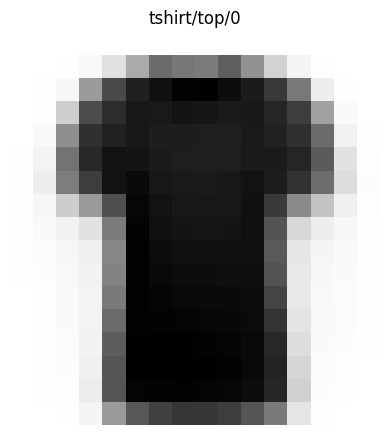

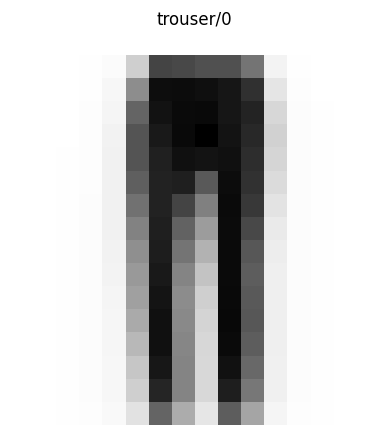

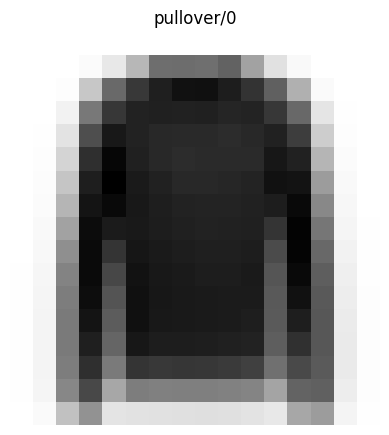

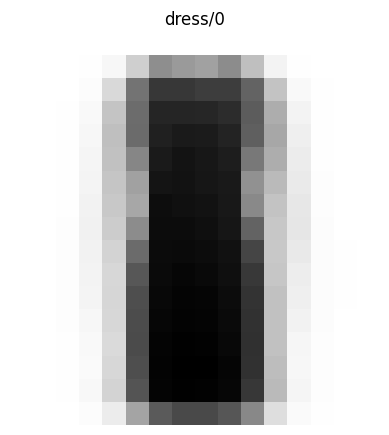

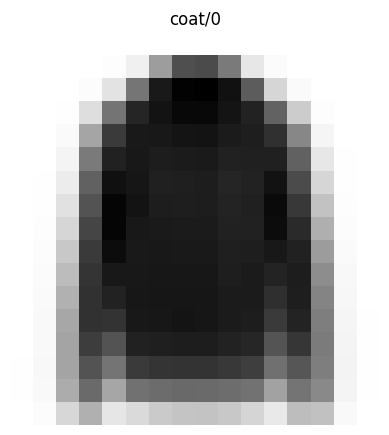

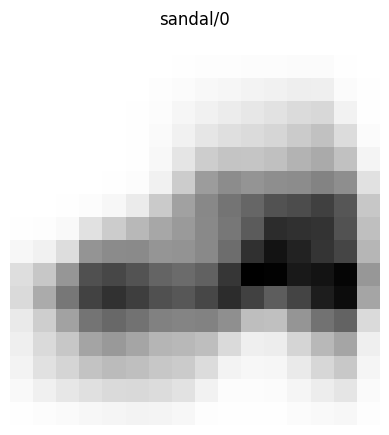

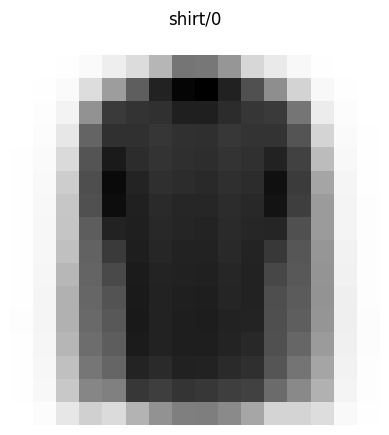

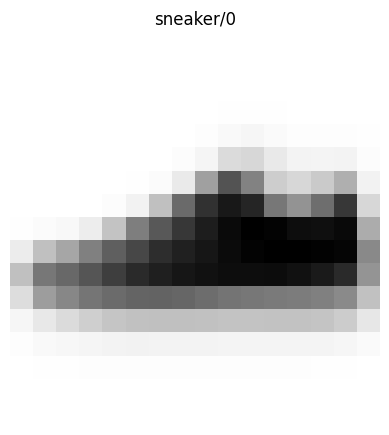

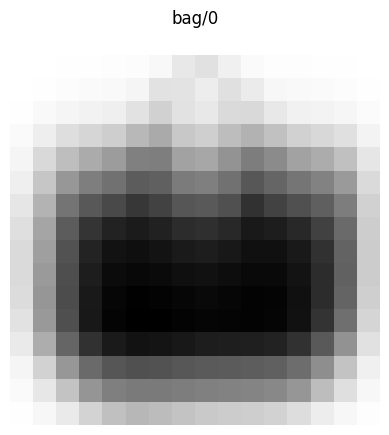

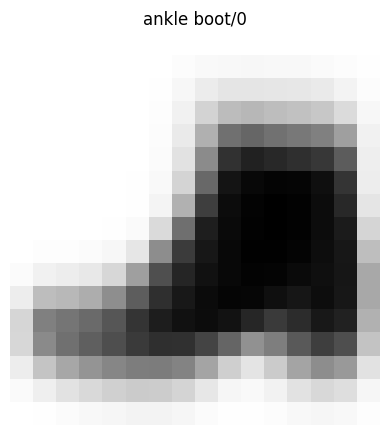

***Training a diagonal GMM with K=3 components***
Label 0: 16 iterations, final MLL      6.976
Label 1: 18 iterations, final MLL     24.300
Label 2: 30 iterations, final MLL      4.003
Label 3: 29 iterations, final MLL     13.942
Label 4: 14 iterations, final MLL      7.669
Label 5: 39 iterations, final MLL      2.003
Label 6: 19 iterations, final MLL      2.574
Label 7: 39 iterations, final MLL     25.045
Label 8: 17 iterations, final MLL    -17.719
Label 9: 28 iterations, final MLL      7.215
K=3: acc train 72.83, acc val 72.43


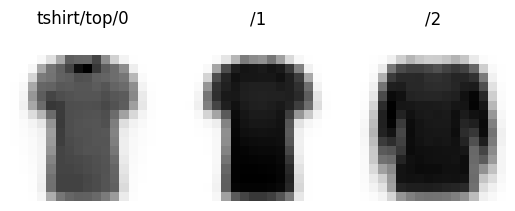

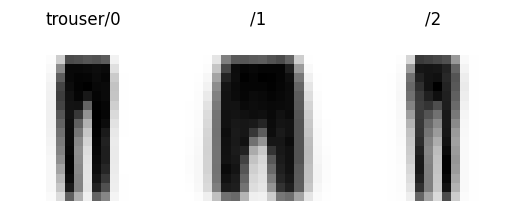

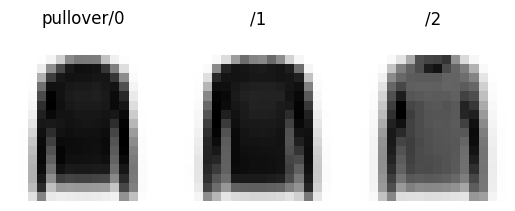

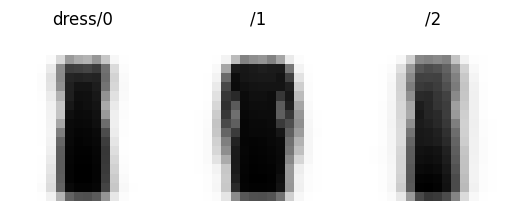

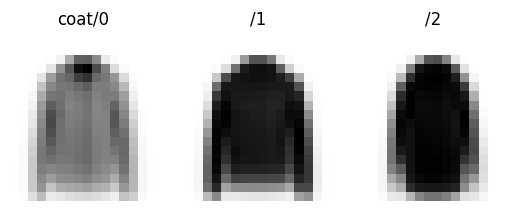

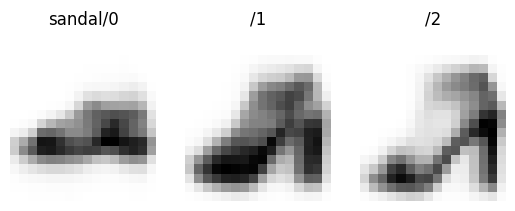

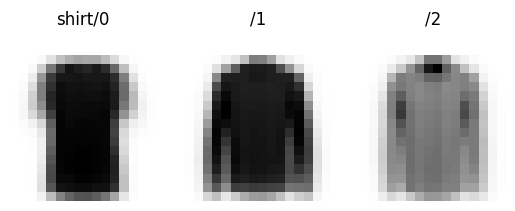

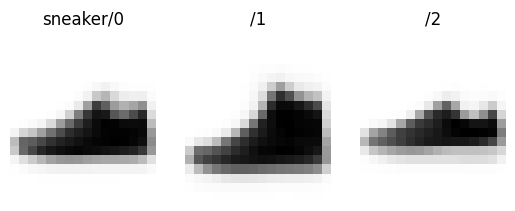

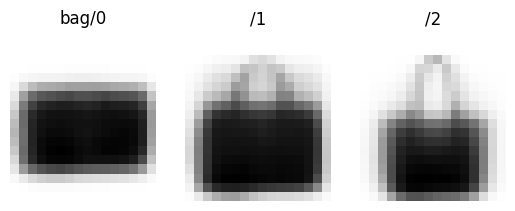

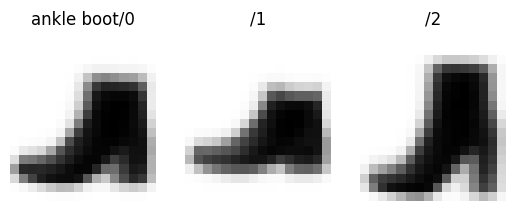

***Training a diagonal GMM with K=8 components***
Label 0: 39 iterations, final MLL     12.515
Label 1: 39 iterations, final MLL     29.661


KeyboardInterrupt: ignored

In [ ]:
set_seed(0)
smoothing = 0.1

for num_components in [1, 3, 8, 11, 13, 15, 19]:
  print('***Training a diagonal GMM with K={:d} components***'.format(num_components))
  models = []
  for y in range(data_train.num_labels):
    model = GMM(data_train.dim, num_components, diag=True)
    trainer = GMMTrainerEM(model, smoothing=smoothing)
    models.append(model)
    mll, iteration = trainer.train(data_train.partition[y], num_iterations_max=40, verbose=False)
    print('Label {:d}: {:2d} iterations, final MLL {:10.3f}'.format(y, iteration, mll))
  acc_train, _ = compute_accuracy(models, data_train)
  acc_val, _ = compute_accuracy(models, data_val)
  print('K={:d}: acc train {:3.2f}, acc val {:3.2f}'.format(num_components, acc_train, acc_val))
  for y in range(10):
    show_means(models, y)
    plt.show()

## <font color=red>Question</font>
For GMMs with diagonal covariance matrices, report
- $K=1$: train acc, val acc
- $K=3$: train acc, val acc

## <font color=red>Answer</font>
write your answer here

1.) $K=1$: acc train 65.01, acc val 64.29

2.) $K=3$: acc train 72.83, acc val 72.43

# Experiments with Full-Covariance GMMs

Similarly we will train full-covariance GMMs for various $K$ values. Again, the training is pretty sensitive to the smoothing parameter. In fact, the marginal log-likelihood may take positive values (invalid!!!) due to numerical instability, but we can still do classification with the model.

***Training a full-covariance GMM with K=1 components***
Label 0:  1 iterations, final MLL  -4873.000
Label 1:  1 iterations, final MLL  -2470.271
Label 2:  1 iterations, final MLL  -5623.915
Label 3:  1 iterations, final MLL  -3928.172
Label 4:  1 iterations, final MLL  -4885.274
Label 5:  1 iterations, final MLL  -4377.308
Label 6:  1 iterations, final MLL  -5876.185
Label 7:  1 iterations, final MLL  -2426.176
Label 8:  1 iterations, final MLL  -7732.448
Label 9:  1 iterations, final MLL  -4738.869
K=1: acc train 67.77, acc val 67.36


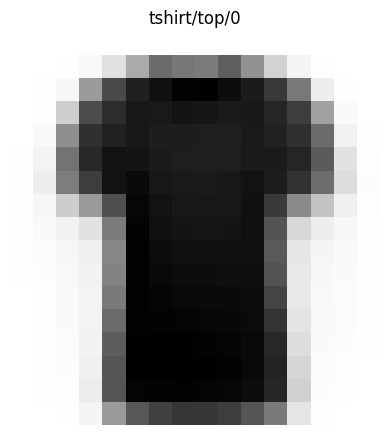

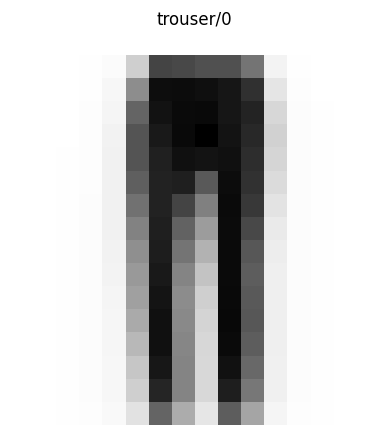

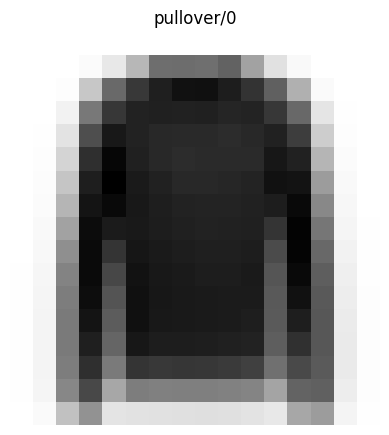

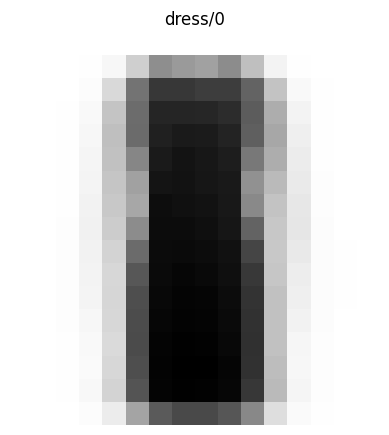

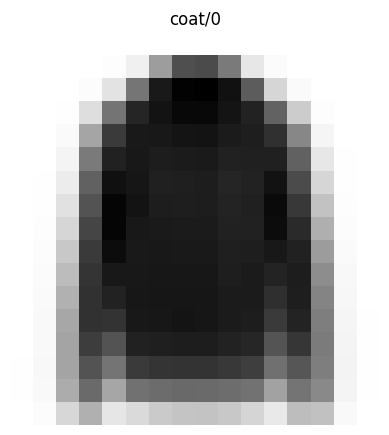

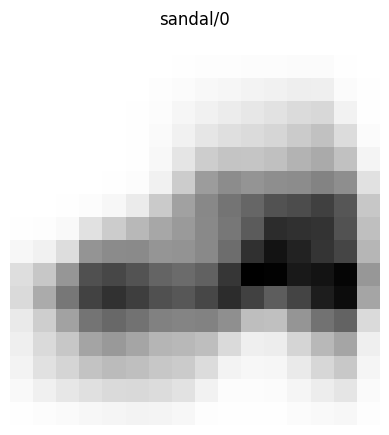

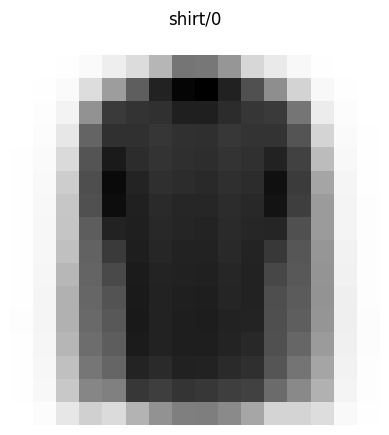

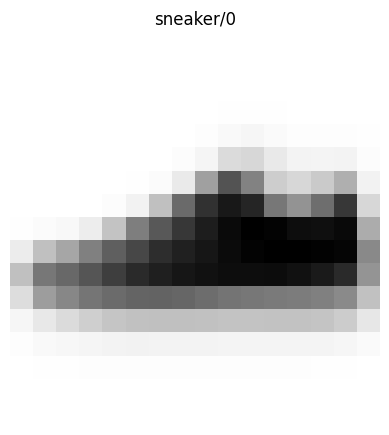

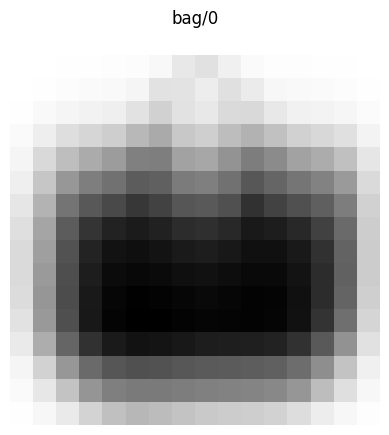

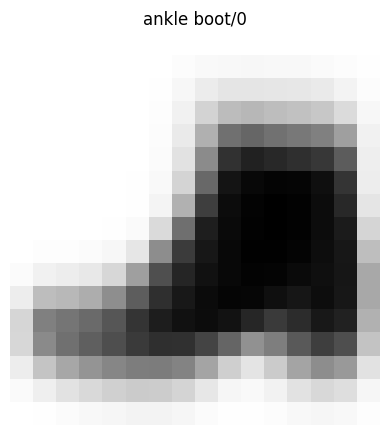

***Training a full-covariance GMM with K=3 components***
Label 0: 35 iterations, final MLL  -2543.134
Label 1: 39 iterations, final MLL  -1507.956
Label 2: 14 iterations, final MLL  -2889.460
Label 3:  9 iterations, final MLL  -2322.109
Label 4:  9 iterations, final MLL  -2762.230
Label 5: 31 iterations, final MLL  -3214.161
Label 6: 14 iterations, final MLL  -2981.759
Label 7: 14 iterations, final MLL  -1471.790
Label 8: 19 iterations, final MLL  -4742.273
Label 9: 22 iterations, final MLL  -2847.543
K=3: acc train 73.55, acc val 72.95


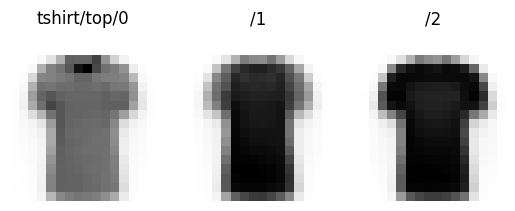

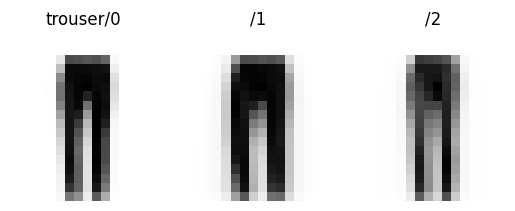

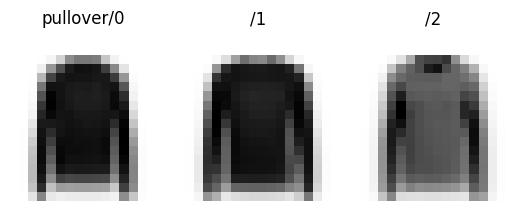

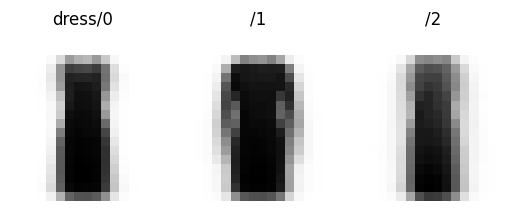

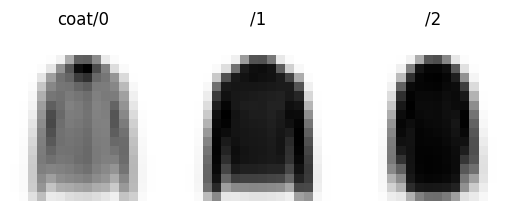

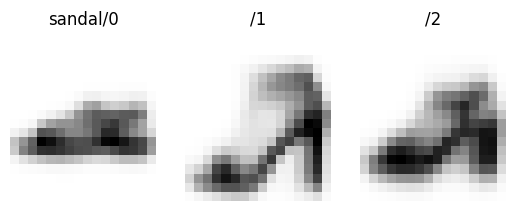

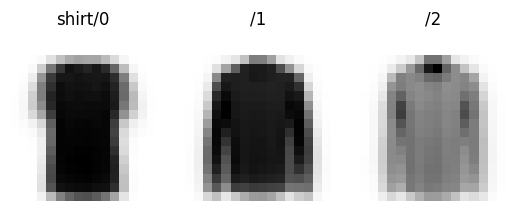

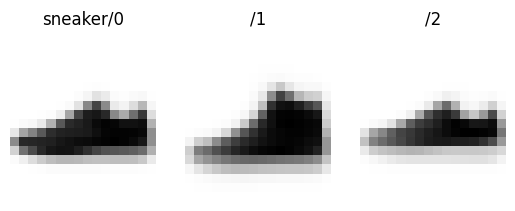

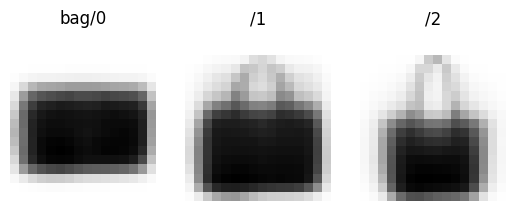

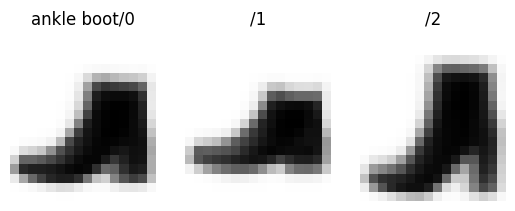

***Training a full-covariance GMM with K=8 components***
Label 0: 28 iterations, final MLL  -1910.814
Label 1: 22 iterations, final MLL  -1027.444
Label 2: 22 iterations, final MLL  -2024.790
Label 3: 39 iterations, final MLL  -1670.705
Label 4: 39 iterations, final MLL  -1856.068
Label 5: 39 iterations, final MLL  -2491.938
Label 6: 23 iterations, final MLL  -2101.689
Label 7: 23 iterations, final MLL  -1019.374
Label 8: 22 iterations, final MLL  -3303.664
Label 9: 23 iterations, final MLL  -2051.442
K=8: acc train 77.56, acc val 76.60


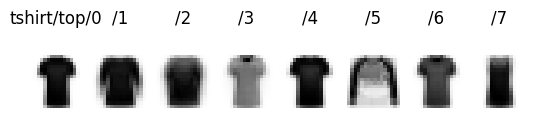

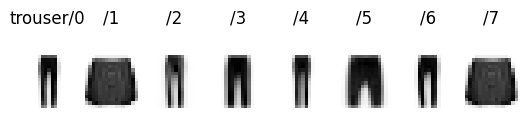

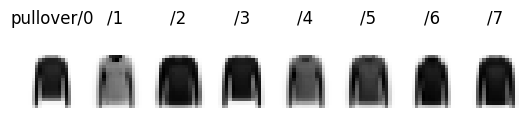

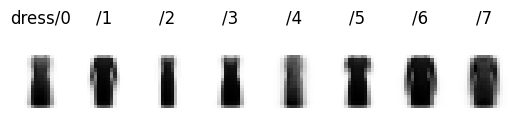

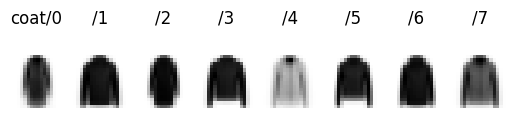

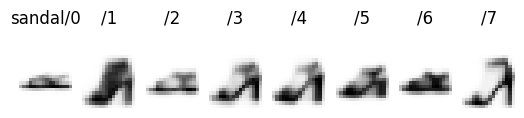

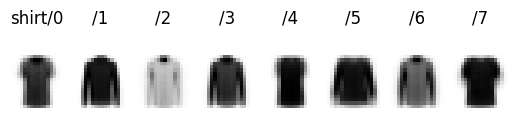

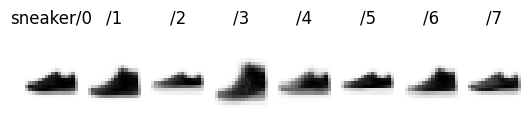

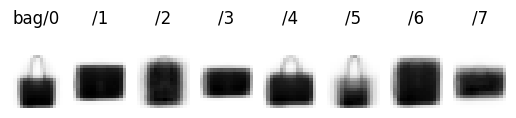

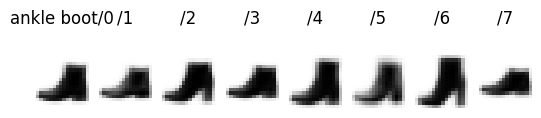

***Training a full-covariance GMM with K=11 components***
Label 0: 39 iterations, final MLL  -1715.029
Label 1: 39 iterations, final MLL   -852.157
Label 2: 32 iterations, final MLL  -1837.555
Label 3: 36 iterations, final MLL  -1507.018
Label 4: 23 iterations, final MLL  -1674.049
Label 5: 32 iterations, final MLL  -2335.032
Label 6: 39 iterations, final MLL  -1934.179
Label 7: 39 iterations, final MLL   -899.385
Label 8: 39 iterations, final MLL  -2968.493
Label 9: 20 iterations, final MLL  -1878.943
K=11: acc train 78.18, acc val 76.97


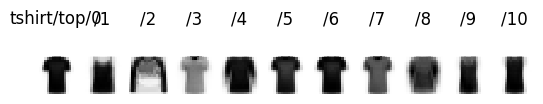

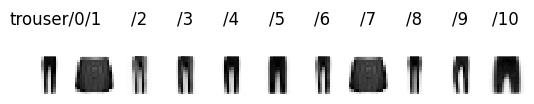

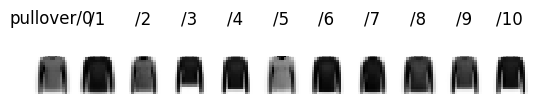

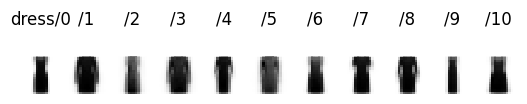

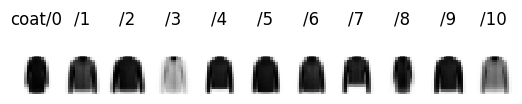

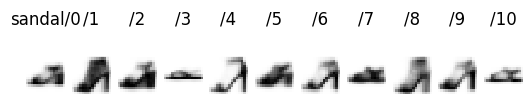

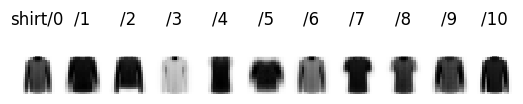

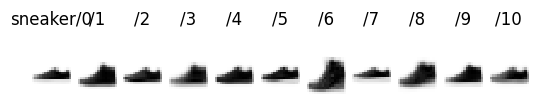

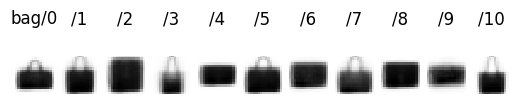

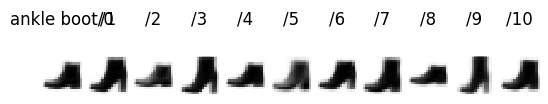

***Training a full-covariance GMM with K=13 components***
Label 0: 39 iterations, final MLL  -1691.177
Label 1: 39 iterations, final MLL   -830.223
Label 2: 39 iterations, final MLL  -1793.244
Label 3: 39 iterations, final MLL  -1437.037
Label 4: 39 iterations, final MLL  -1606.384
Label 5: 39 iterations, final MLL  -2281.299
Label 6: 39 iterations, final MLL  -1882.349
Label 7: 22 iterations, final MLL   -876.340
Label 8: 37 iterations, final MLL  -2768.956
Label 9: 39 iterations, final MLL  -1807.877
K=13: acc train 79.06, acc val 77.98


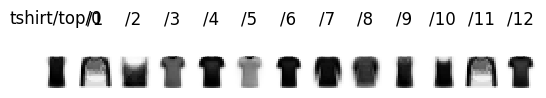

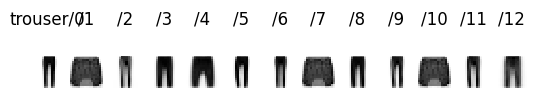

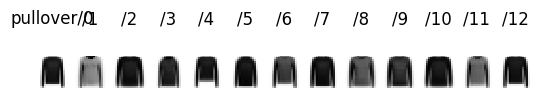

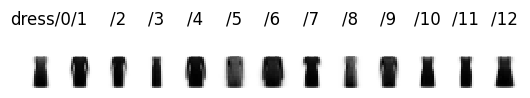

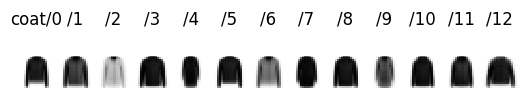

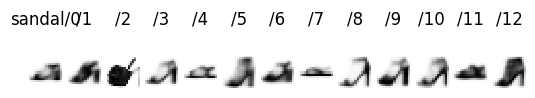

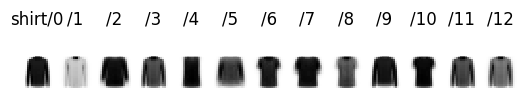

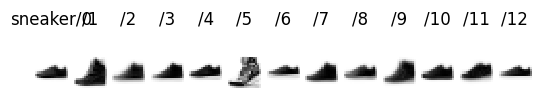

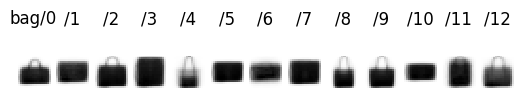

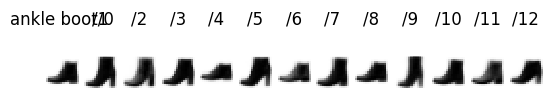

***Training a full-covariance GMM with K=15 components***
Label 0: 39 iterations, final MLL  -1640.514
Label 1: 39 iterations, final MLL   -761.926
Label 2: 39 iterations, final MLL  -1764.309
Label 3: 39 iterations, final MLL  -1408.580
Label 4: 39 iterations, final MLL  -1538.045
Label 5: 39 iterations, final MLL  -2200.057
Label 6: 39 iterations, final MLL  -1794.061
Label 7: 39 iterations, final MLL   -836.780
Label 8: 39 iterations, final MLL  -2733.774
Label 9: 39 iterations, final MLL  -1756.788
K=15: acc train 79.18, acc val 77.99


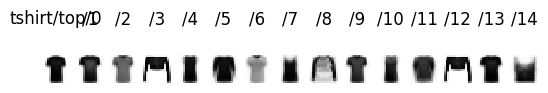

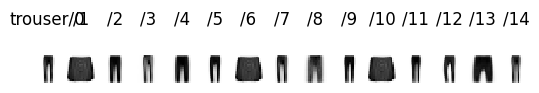

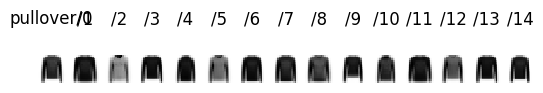

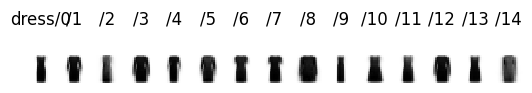

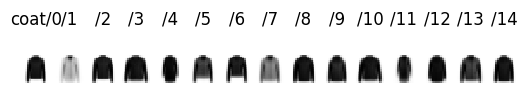

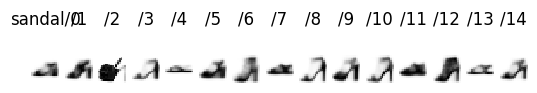

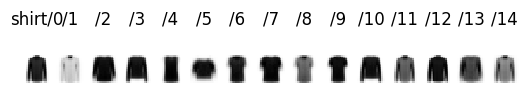

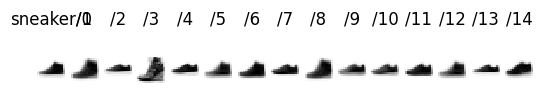

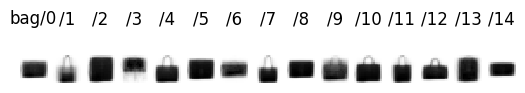

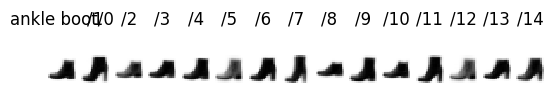

***Training a full-covariance GMM with K=19 components***
Label 0: 34 iterations, final MLL  -1538.327
Label 1: 26 iterations, final MLL   -766.906
Label 2: 39 iterations, final MLL  -1651.321
Label 3: 39 iterations, final MLL  -1334.350
Label 4: 29 iterations, final MLL  -1492.629
Label 5: 39 iterations, final MLL  -2119.621
Label 6: 35 iterations, final MLL  -1690.220
Label 7: 39 iterations, final MLL   -789.173
Label 8: 27 iterations, final MLL  -2578.848
Label 9: 29 iterations, final MLL  -1741.706
K=19: acc train 80.33, acc val 78.62


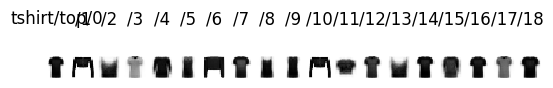

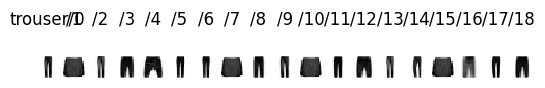

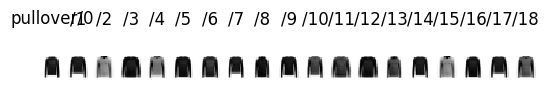

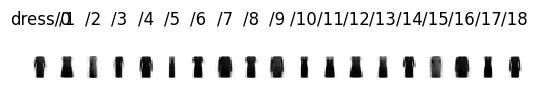

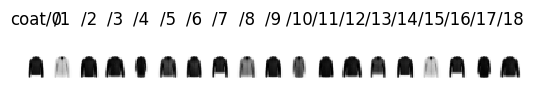

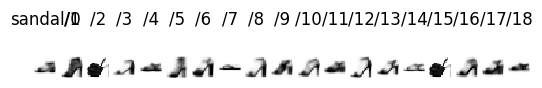

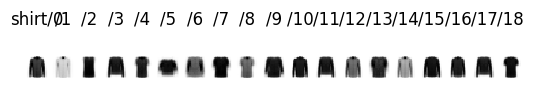

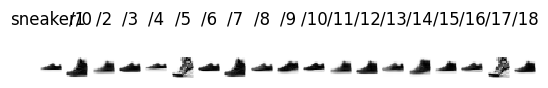

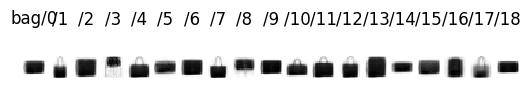

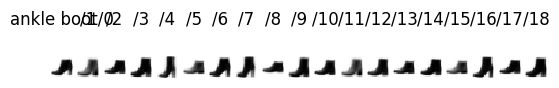

In [ ]:
set_seed(0)
smoothing = 0.001

for num_components in [1, 3, 8, 11, 13, 15, 19]:
  print('***Training a full-covariance GMM with K={:d} components***'.format(num_components))
  models = []
  for y in range(data_train.num_labels):
    model = GMM(data_train.dim, num_components, diag=False)
    trainer = GMMTrainerEM(model, smoothing=smoothing)
    models.append(model)
    mll, iteration = trainer.train(data_train.partition[y], num_iterations_max=40, verbose=False)
    print('Label {:d}: {:2d} iterations, final MLL {:10.3f}'.format(y, iteration, mll))
  acc_train, _ = compute_accuracy(models, data_train)
  acc_val, _ = compute_accuracy(models, data_val)
  print('K={:d}: acc train {:3.2f}, acc val {:3.2f}'.format(num_components, acc_train, acc_val))
  for y in range(10):
    show_means(models, y)
    plt.show()

## <font color=red>Question</font>
For GMMs with full covariance matrices, report
- $K=1$
- $K=3$

## <font color=red>Answer</font>
1.) - $K=1:$ acc train 67.77, acc val 67.36

2.) - $K=3:$ acc train 73.55, acc val 72.95


---

## <font color=red>Question</font>
Explore the model space with different settings: varying number of components across classes (required), covariance matrix restrictions (required), initialization of GMM, convergence criteria of training, etc
- Report the setting and val accuracy of your single **best model**.
- Describe (in detail) the **trend in accuracies** (train and val) across settings
- Describe (in detail) the **trend in visualized cluster** (displayed by the showMeans function) across settings


## <font color=red>Answer</font>
write your answer here:

-Report the setting and val accuracy of your single **best model**:






>The best model I was able to get was found within the full-covariance matrix settings: **K=19: acc train 80.33, acc val 78.62**


>The trends in accuracies is that the more you increase your k components, you steadily increase the training accuracy as well possibly the validation accuracy. However once you reach the highest point, eventually the more k components you try to attempt afterward tends to trail off or go into smaller values again.

>When calculating with full covariance matrices, our computations exponentially take more time the more we increase the k-component. Meanwhile with the diagonal the amount of computation time was reasonably faster in comparison, despite increasing the k-component values.

>In terms of the the trend in visualized cluster, the more we increase our K components, the more clear our visuals become of each clothing item within the diagonal and full covariance matrix.
